<a href="https://colab.research.google.com/github/cing3000/Reinforcement-Learning-An-Introduction/blob/master/Reinforcement_Learning_Notebook_Chapter_13_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 13: Policy Gradient Methods

Methods learn a _parameterized policy_ that can select actions without consulting a value function.

The policy parameter is learned based on the gradient of some performance measure $J(\theta)$ with respect to the policy parameter.

## 13.1 Policy Approximation and its Advantages

If the action space is discrete and not too large, then a natural kind of parameterization is to form parameterized numerical preferences $h(s,a,\boldsymbol{\theta}) \in \mathbb{R}$ for each state-action pair.

$$ \pi(a|s, \boldsymbol{\theta})=\frac{e^{h(s,a,\boldsymbol{\theta})}}{\sum_be^{h(s,a,\boldsymbol{\theta})}} \tag{13.2}$$

Advantages over action-value methods:
* The approximate policy can approach a deterministic policy
* The best approximate policy may be stochastic
* The policy may be a simpler function to approximate
* The choice of policy parameterization is sometimes a good way of injecting prior knowldge about the desired form of the policy into the RL system.



** Example 13.1 Short corridor with switched actions **

True value calculation according to (3.14)

<font color='red'>$$ v_\pi(s) \doteq \sum_a\pi(a\mid s)\sum_{s',r}p(s',r\mid s,a)\big[r+\gamma v_\pi(s')\big] \tag{3.14}$$</font>

$$ \begin{cases} v(0)=(1-p)[-1+v(0)]+p[-1+v(1)] \\ 
v(1)=(1-p)[-1+v(2)]+p[-1+v(0)] \\
v(2)=(1-p)[-1+v(1)]+p(-1)\end{cases} \implies v(0)=\frac{4-2p}{p(p-1)}$$

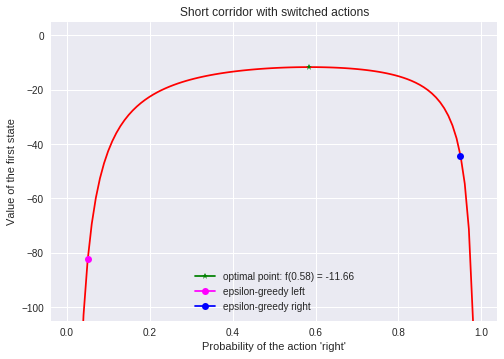

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Optimal v
def optimal_v(p):
    """
        Optimal value of the first state
        
    Args:
        p (float): probability of the action 'right'.
    Returns:
        True value of the first state
    """
    return (4-2*p)/(p*(p-1))

def example_13_1():
    epsilon = 0.05
    fig, ax = plt.subplots(1, 1)

    # Plot a graph
    p = np.linspace(0.01, 0.99, 100)
    y = optimal_v(p)
    ax.plot(p, y, color='red')

    # Find a maximum point, can also be done analytically by taking a derivative
    imax = np.argmax(y)
    pmax = p[imax]
    ymax = y[imax]
    ax.plot(pmax, ymax, color='green', marker="*", label="optimal point: f({0:.2f}) = {1:.2f}".format(pmax, ymax))

    # Plot points of two epsilon-greedy policies
    ax.plot(epsilon, optimal_v(epsilon), color='magenta', marker="o", label="e-greedy left")
    ax.plot(1 - epsilon, optimal_v(1 - epsilon), color='blue', marker="o", label="e-greedy right")

    ax.set_ylabel("Value of the first state")
    ax.set_xlabel("Probability of the action 'right'")
    ax.set_title("Short corridor with switched actions")
    ax.set_ylim(ymin=-105.0, ymax=5)
    ax.legend()
    
    plt.show()

example_13_1()

## 13.2 The Policy Gradient Theorem

The performance can be defined as:
$$ J(\theta)\doteq v_{\pi_\boldsymbol{\theta}}(s_0) \tag{13.4}$$
where $v_{\pi_\boldsymbol{\theta}}$ is the true value function for $\pi_\boldsymbol{\theta}$, the policy determinded by $\boldsymbol{\theta}$.

The policy gradient theorem establishes that:
$$ \nabla J(\boldsymbol{\theta})\propto \sum_s\mu(s)\sum_aq_\pi(s,a)\nabla_\boldsymbol{\theta}\pi(a|s, \boldsymbol{\theta}), \tag{13.5}$$

The distribution $\mu$ is the on-policy distribution under $\pi$.

## 13.3 REINFORCE: Monte Carlo Policy Gradient

REINFORCE:

$$ \boldsymbol{\theta}_{t+1} \doteq \boldsymbol{\theta}_t+\alpha G_t \frac{\nabla_{\boldsymbol{\theta}}\pi(A_t|S_t, \boldsymbol{\theta}_t)}{\pi(A_t|S_t, \boldsymbol{\theta}_t)} \tag{13.6}$$

** REINFORCE, A Monte-Carlo Policy-Gradient Method (episodic) **

---

Input: a differentiable policy parameterization $\pi(a|s, \boldsymbol{\theta})$<br/>
Initialize policy parameter $\boldsymbol{\theta}\in \mathbb{R}^{d'}$<br/>
Repeat forever:
>Generate an episode $S_0, A_0, R_1, \dots S_{T-1}, A_{T-1}, R_T$, following $\pi(\cdot|\cdot, \boldsymbol{\theta})$<br/>
>For each step of the episode $t=0, \dots, T-1$:
>>$G\leftarrow $ return from step $t$<br/>
>>$\boldsymbol{\theta}\leftarrow \boldsymbol{\theta}+\alpha \gamma^tG\nabla_\boldsymbol{\theta}\ln\pi(A_t|S_t, \boldsymbol{\theta}) $

---



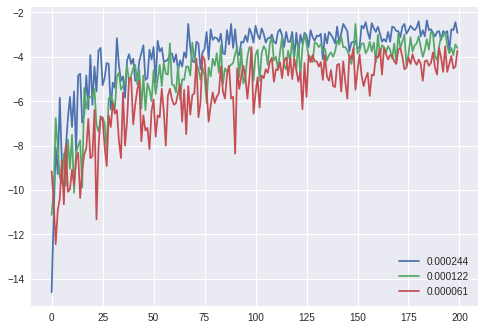

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time

# softmax
def softmax(h):
    exp = np.exp(h-np.max(h))
    return exp/np.sum(exp, axis=-1)


# define environment
class Corridor:
    
    def __init__(self):
        
        self.action_space = [-1, 1]
        
        self.reset()
    
    # reset environment
    def reset(self):
        self.state = 0

    def step(self, action):
        a = self.action_space[action]
        
        r = -1
        done = False
        
        # reverse action in the second state
        if self.state == 1:
            a *= -1
        
        # apply action
        self.state += a
        
        # no more left in the first state
        if self.state < 0:
            self.state = 0
        
        # terminal ?
        if self.state == 3:
            r = 0
            done = True
        
        return self.state, r, done

# global variables
episodes = 5000
#alpha = 2**(-13)
gamma = 1
epsilon = 0.05

# REINFORCE, A Monte-Carlo Policy-Gradient Method
def reinforce(alpha):
    theta = np.zeros([3,2])
    x = np.array([[1,0], [0,1]])
    
    def pi(s):
        pmf = softmax(np.dot(theta[s], x))
        imin = np.argmin(pmf)
        
        if pmf[imin] < 0.05:
            pmf[:] = 1-epsilon
            pmf[imin] = epsilon

        return pmf
    
    rewards = []

    for epoch in range(episodes):
        
        # list for storing states, actions and rewards
        states = []
        actions = []
        rs = []
        
        reward = 0
        
        # initialize environment
        env = Corridor()
        env.reset()
        done = False
        
        # S0
        s = env.state
        states.append(s)
        
        # generate an episode
        while not done:
            a = 0 if np.random.rand() < pi(s)[0] else 1
            new_s, r, done = env.step(a)
            
            states.append(new_s)
            actions.append(a)
            rs.append(r)
            
            s = new_s
            reward += r
            
        # record episode reward
        rewards.append(reward)
        
        # calculate G
        G = np.zeros(len(rs))
        G[-1] = rs[-1]
        for i in range(2, len(rs)+1):
            G[-i] = gamma * G[-i+1] + rs[-i]

        gamma_pow = 1
            
        # update theta
        for t in range(len(rs)):
            s = states[t]
            a = actions[t]

            grad = x[a] - np.dot(pi(s), x)
            #print(grad)
            theta[s] += alpha * gamma_pow * G[t] * grad
            
            gamma_pow *= gamma
        
        #print(theta)
        
    # plot rewards
    plt.plot(np.mean(np.array(rewards).reshape(-1, 25), axis=1), label='%f' % alpha)
    #plt.plot(rewards, label='%f' % alpha)


reinforce(2**-12)
reinforce(2**-13)
reinforce(2**-14)
plt.legend()
plt.show()

Try to implement the same algorithm in tensorflow

100%|██████████| 5000/5000 [00:34<00:00, 145.24it/s]


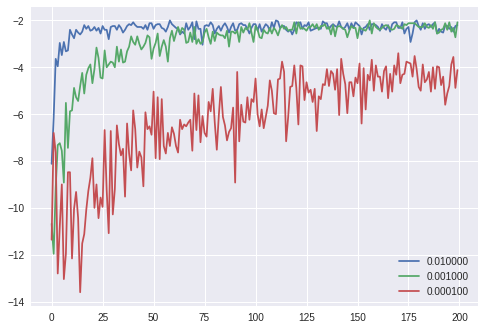

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import tensorflow as tf

# softmax
def softmax(h):
    exp = np.exp(h-np.max(h))
    return exp/np.sum(exp, axis=-1)


# define environment
class Corridor:
    
    def __init__(self):
        
        self.action_space = [-1, 1]
        
        self.reset()
    
    # reset environment
    def reset(self):
        self.state = 0

    def step(self, action):
        a = self.action_space[action]
        
        r = -1
        done = False
        
        # reverse action in the second state
        if self.state == 1:
            a *= -1
        
        # apply action
        self.state += a
        
        # no more left in the first state
        if self.state < 0:
            self.state = 0
        
        # terminal ?
        if self.state == 3:
            r = 0
            done = True
        
        return self.state, r, done

# global variables
episodes = 5000
#alpha = 2**(-13)
gamma = 1
epsilon = 0.05


# REINFORCE, A Monte-Carlo Policy-Gradient Method
def reinforce(alpha):
    
    graph = tf.Graph()
    with graph.as_default():
        in_state = tf.placeholder(shape=[None, 3], dtype=tf.float32)
        W = tf.Variable(tf.zeros((3, 2), dtype=tf.float32))
        output = tf.nn.softmax(tf.matmul(in_state, W))
        
        #in_reward = tf.placeholder(dtype=tf.float32)
        #in_action = tf.placeholder(dtype=tf.int32)
        
        #indexes = tf.range(0, tf.shape(output)[0]) * tf.shape(output)[1] + in_action
        #loss = -tf.reduce_mean(tf.log(tf.gather(tf.reshape(output, [-1]), indexes)) * in_reward)
        
        in_reward = tf.placeholder(dtype=tf.float32)
        in_action = tf.placeholder(dtype=tf.int32)
        loss = -tf.reduce_mean(tf.log(output[0, in_action]) * in_reward)

        tvars = tf.trainable_variables()
        gradients = tf.gradients(loss, tvars)
        optimizer = tf.train.AdamOptimizer(learning_rate=alpha).apply_gradients(zip(gradients, tvars))

    
    with tf.Session(graph=graph) as sess:
    
        tf.global_variables_initializer().run()
        
        # policy function
        def pi(s):
            state = np.zeros((1, 3))
            state[0, s] = 1.0
            pmf = sess.run([output], feed_dict={in_state: state})[0][0]
            imin = np.argmin(pmf)

            if pmf[imin] < 0.05:
                pmf[:] = 1-epsilon
                pmf[imin] = epsilon

            return pmf
    
        rewards = []

        for epoch in tqdm(range(episodes)):

            # list for storing states, actions and rewards
            states = []
            actions = []
            rs = []

            reward = 0

            # initialize environment
            env = Corridor()
            env.reset()
            done = False

            # S0
            s = env.state
            states.append(s)

            # generate an episode
            while not done:
                a = 0 if np.random.rand() < pi(s)[0] else 1
                new_s, r, done = env.step(a)

                states.append(new_s)
                actions.append(a)
                rs.append(r)

                s = new_s
                reward += r

            # record episode reward
            rewards.append(reward)

            # calculate G
            G = np.zeros(len(rs))
            G[-1] = rs[-1]
            for i in range(2, len(rs)+1):
                G[-i] = gamma * G[-i+1] + rs[-i]

            # train
            for t in range(len(rs)):
                s = states[t]
                a = actions[t]
                
                state = np.zeros((1, 3))
                state[0, s] = 1.0
                
                _, _ = sess.run([output, optimizer],
                         feed_dict={in_state: state, in_reward: G[t], in_action: a})

    # plot rewards
    plt.plot(np.mean(np.array(rewards).reshape(-1, 25), axis=1), label='%f' % alpha)
    #plt.plot(rewards, label='%f' % alpha)


reinforce(1e-2)
reinforce(1e-3)
reinforce(1e-4)
plt.legend()
plt.show()

## 13.4 REINFORCE with Baseline

The policy gradient theorem (13.5) can be generalized to include a comparison of the action value to an arbitrary _baseline $b(s)$_:

$$ \nabla J(\boldsymbol{\theta})\propto\sum_s\mu(s)\sum_a\Big(q_\pi(s,a)-b(s)\Big)\nabla_\boldsymbol{\theta}\pi(a|s,\boldsymbol{\theta}) \tag{13.8}$$

REINFORCE with a general baseline:

$$ \boldsymbol{\theta}_{t+1} \doteq \boldsymbol{\theta}_t+\alpha \Big(G_t-b(S_t)\Big) \frac{\nabla_{\boldsymbol{\theta}}\pi(A_t|S_t, \boldsymbol{\theta}_t)}{\pi(A_t|S_t, \boldsymbol{\theta}_t)} \tag{13.9}$$

One natural choice for the baseline is an estimate of the state value, $\hat{v}(S_t, \mathbf{w})$, where $\mathbf{w} \in \mathbb{R}^m$ is a weight vector learned by some method.

<br/>

**REINFORCE with Baseline (episodic)**

---

Input: a differentiable policy parameterization $\pi(a|s, \boldsymbol{\theta})$<br/>
Input: a differentiable state-value parameterization $\hat{v}(s, \mathbf{w})$<br/>
Parameters: step sizes $\alpha^\boldsymbol{\theta}\gt0, \alpha^\mathbf{w}\gt0$

Initialize policy parameter $\boldsymbol{\theta}\in \mathbb{R}^{d'}$ and state-value weights $\mathbf{w}\in \mathbb{R}^{d}$<br/>
Repeat forever:
>Generate an episode $S_0, A_0, R_1, \dots S_{T-1}, A_{T-1}, R_T$, following $\pi(\cdot|\cdot, \boldsymbol{\theta})$<br/>
>For each step of the episode $t=0, \dots, T-1$:
>>$G\leftarrow $ return from step $t$<br/>
>>$\delta\leftarrow G_t-\hat{v}(S_t, \mathbf{w})$<br/>
>>$\mathbf{w}\leftarrow \mathbf{w}+\alpha^\mathbf{w} \gamma^t\delta\nabla_\mathbf{w}\hat{v}(S_t, \mathbf{w}) $<br/>
>>$\boldsymbol{\theta}\leftarrow \boldsymbol{\theta}+\alpha^\boldsymbol{\theta} \gamma^t\delta \nabla_\boldsymbol{\theta}\ln\pi(A_t|S_t, \boldsymbol{\theta}) $

---

## 13.5 Actor-Critic Methods

$$ \boldsymbol{\theta}_{t+1} \doteq \boldsymbol{\theta}_t+\alpha \Big(R_{t+1}+\gamma\hat{v}(S_{t+1}, \mathbf{w})-\hat{v}(S_t, \mathbf{w})\Big) \frac{\nabla_{\boldsymbol{\theta}}\pi(A_t|S_t, \boldsymbol{\theta}_t)}{\pi(A_t|S_t, \boldsymbol{\theta}_t)} \tag{13.11}$$

<br/>

** One-step Actor-Critic (episodic) **

---

Input: a differentiable policy parameterization $\pi(a|s, \boldsymbol{\theta})$<br/>
Input: a differentiable state-value parameterization $\hat{v}(s, \mathbf{w})$<br/>
Parameters: step sizes $\alpha^\boldsymbol{\theta}\gt0, \alpha^\mathbf{w}\gt0$

Initialize policy parameter $\boldsymbol{\theta}\in \mathbb{R}^{d'}$ and state-value weights $\mathbf{w}\in \mathbb{R}^{d}$<br/>
Repeat forever:
>Initialize $S$ (first state of episode)<br/>
>$I \leftarrow 1 $<br/>
>While $S$ is not terminal:
>>$A \sim \pi(\cdot|S, \boldsymbol{\theta})$ <br/>
>>Take action $A$, observe $S', R$<br/>
>>$\delta\leftarrow R+\gamma\hat{v}(S', \mathbf{w})-\hat{v}(S, \mathbf{w})$<br/>
>>$\mathbf{w}\leftarrow \mathbf{w}+\alpha^\mathbf{w} I\delta\nabla_\mathbf{w}\hat{v}(S, \mathbf{w}) $<br/>
>>$\boldsymbol{\theta}\leftarrow \boldsymbol{\theta}+\alpha^\boldsymbol{\theta} I\delta \nabla_\boldsymbol{\theta}\ln\pi(A_t|S_t, \boldsymbol{\theta}) $<br/>
>>$I\leftarrow \gamma I$<br/>
>>$S\leftarrow S'$

---

** Actor-Critic with Eligibility Traces (episodic) **

---



---

The same problem in Actor-Critic with ANN

100%|██████████| 5000/5000 [01:09<00:00, 71.43it/s] 


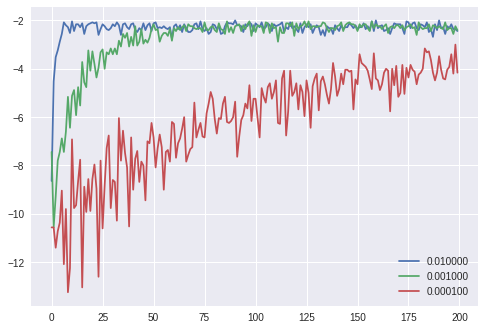

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import tensorflow as tf

# softmax
def softmax(h):
    exp = np.exp(h-np.max(h))
    return exp/np.sum(exp, axis=-1)


# define environment
class Corridor:
    
    def __init__(self):
        
        self.action_space = [-1, 1]
        
        self.reset()
    
    # reset environment
    def reset(self):
        self.state = 0

    def step(self, action):
        a = self.action_space[action]
        
        r = -1
        done = False
        
        # reverse action in the second state
        if self.state == 1:
            a *= -1
        
        # apply action
        self.state += a
        
        # no more left in the first state
        if self.state < 0:
            self.state = 0
        
        # terminal ?
        if self.state == 3:
            r = 0
            done = True
        
        return self.state, r, done

# global variables
episodes = 5000
#alpha = 2**(-13)
gamma = 1
epsilon = 0.05


# REINFORCE, A Monte-Carlo Policy-Gradient Method
def reinforce(alpha_w, alpha_theta):
    
    graph = tf.Graph()
    with graph.as_default():
        
        in_state = tf.placeholder(shape=[1, 3], dtype=tf.float32)
        theta = tf.Variable(tf.zeros((3, 2), dtype=tf.float32), name="theta")
        out_action = tf.nn.softmax(tf.matmul(in_state, theta))
        
        w = tf.Variable(tf.zeros((3, 1), dtype=tf.float32), name="w")
        out_v = tf.matmul(in_state, w)
        
        in_action = tf.placeholder(dtype=tf.int32)
        
        loss_w = -out_v
        loss_theta = -tf.reduce_mean(tf.log(out_action[0, in_action]))

        vars_theta = tf.trainable_variables(scope="theta")
        vars_w = tf.trainable_variables(scope="w")
        
        grad_theta = tf.gradients(loss_theta, vars_theta)
        grad_w = tf.gradients(loss_w, vars_w)
        
        in_grad_theta = []
        in_grad_w = []
        for idx, grad in enumerate(vars_theta):
            placeholder = tf.placeholder(tf.float32, name=str(idx)+'_holder')
            in_grad_theta.append(placeholder)
        for idx, grad in enumerate(vars_w):
            placeholder = tf.placeholder(tf.float32, name=str(idx)+'_holder')
            in_grad_w.append(placeholder)
        
        opt_theta = tf.train.AdamOptimizer(learning_rate=alpha_theta)
        opt_w = tf.train.AdamOptimizer(learning_rate=alpha_w)
        
        update_theta = opt_theta.apply_gradients(zip(in_grad_theta, vars_theta))
        update_w = opt_w.apply_gradients(zip(in_grad_w, vars_w))

    
    with tf.Session(graph=graph) as sess:
    
        tf.global_variables_initializer().run()
        
        # policy function
        def pi(s):
            state = np.zeros((1, 3))
            state[0, s] = 1.0
            pmf = sess.run(out_action, feed_dict={in_state: state})[0]
            imin = np.argmin(pmf)

            if pmf[imin] < 0.05:
                pmf[:] = 1-epsilon
                pmf[imin] = epsilon

            return pmf
    
        rewards = []

        for epoch in tqdm(range(episodes)):

            # list for storing states, actions and rewards
            reward = 0

            # initialize environment
            env = Corridor()
            env.reset()
            done = False

            # S0
            s = env.state
            i = 1.0

            # generate an episode
            while not done:
                a = 0 if np.random.rand() < pi(s)[0] else 1
                s1, r, done = env.step(a)
                
                if not done:
                    state = np.zeros((1,3))
                    state1 = np.zeros((1,3))
                    state[0, s] = 1.0
                    state1[0, s1] = 1.0

                    v = sess.run(out_v, feed_dict={in_state: state})
                    v1 = sess.run(out_v, feed_dict={in_state: state1})

                    g_t, g_w = sess.run([grad_theta, grad_w],
                                        feed_dict={in_state: state, in_action: a})

                    delta = r + gamma*v1 - v
                    g_t = i*delta*g_t
                    g_w = i*delta*g_w

                    _= sess.run([update_theta], feed_dict=dict(zip(in_grad_theta, g_t)))
                    _= sess.run([update_w], feed_dict=dict(zip(in_grad_w, g_w)))

                s = s1
                i *= gamma
                reward += r

            # record episode reward
            rewards.append(reward)

    # plot rewards
    plt.plot(np.mean(np.array(rewards).reshape(-1, 25), axis=1), label='%f' % alpha_w)
    #plt.plot(rewards, label='%f' % alpha_w)


reinforce(1e-2, 1e-2)
reinforce(1e-3, 1e-3)
reinforce(1e-4, 1e-4)
plt.legend()
plt.show()

## 13.6 Policy Gradient for Continuing Problems

Define performance in terms of the average rate of reward per time step:

$$ \begin{align} J(\boldsymbol{\theta})\doteq r(\pi) & \doteq \lim_{h\rightarrow\infty}\frac{1}{h}\sum_{t=1}^{h}\mathbb{E}\big[R_t|A_{0:t-1}\sim\pi\big] \\ &=\lim_{t\rightarrow\infty}\mathbb{E}\big[R_t|A_{0:t-1}\sim\pi\big] \\
&=\sum_s\mu(s)\sum_a\pi(a|s)\sum_{s',r}p(s',r|s,a)r,  \end{align} \tag{13.13}$$

The policy gradient theorem as given for the episodic case (13.5) remains true for the continuing case.

** Actor_Critic with Eligibility Traces (continuing) **

---

---



## 13.7 Policy Parameterization for Continuous Actions

Instead of computing learned probabilities for each of the many actions, we instead learn statistics of the probability distribution.

To produce a policy parameterization, the policy can be defined as the normal probability density over a real-valued scalar action, with mean and standard deviation given by parametric function approimators that depend on the state.

$$ \pi(a|s,\boldsymbol{\theta})\doteq\frac{1}{\sigma(s,\boldsymbol{\theta})\sqrt{2\pi}}exp\Big(-\frac{(a-\mu(s,\boldsymbol{\theta}))^2}{2\sigma(s,\boldsymbol{\theta})^2}\Big), \tag{13.17}$$

where $\mu:\mathcal{S}\times\mathbb{R}^{d'}\rightarrow\mathbb{R}$ and $\sigma:\mathcal{S}\times\mathbb{R}^{d'}\rightarrow\mathbb{R}^+$ are two parameterized function approximators.